In [1]:
import pandas as pd
import numpy as np
import time

from itertools import combinations
import networkx as nx

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

In [3]:
import node2vec
from gensim.models import Word2Vec

In [4]:
pd.options.display.max_rows = 100

In [13]:
def create_graph_from_frame(frame_df:pd.DataFrame, nfl_id_tuples:list=None, nfl_ids:np.array=None):
    all_dists_mat = np.linalg.norm(frame_df.loc[:,['x','y']].values - frame_df.loc[:,['x','y']].values[:,None], axis=-1)
    all_dists_tri = all_dists_mat[np.triu_indices(all_dists_mat.shape[0], k=1)]

    if nfl_id_tuples is None:
        nfl_id_tuples = list(combinations(frame_df.nflId, r=2))

    list_of_weight_dics = [{"weight":dist} for dist in all_dists_tri]   # create bc that's input for nx_graph
    edges = [(nfl_id_tuples[i][0], nfl_id_tuples[i][1], list_of_weight_dics[i]) for i in range(len(nfl_id_tuples))]

    nx_G = nx.Graph()
    if nfl_ids is None:
        nx_G.add_nodes_from(frame_df.nflId)
    else:
        nx_G.add_nodes_from(nfl_ids)
    nx_G.add_edges_from(edges)
    nx_G = nx_G.to_undirected()

    return nx_G

In [14]:
# from node2vec github repo
def learn_embeddings(walks):
	dimensions=32
	window_size=10
	epoch_iters = 1

	'''
	Learn embeddings by optimizing the Skipgram objective using SGD.
	'''
	walks = [list(map(str, walk)) for walk in walks]
	model = Word2Vec(walks, vector_size=dimensions, window=window_size, min_count=0, sg=1, workers=1, epochs=epoch_iters)
	#model.save_word2vec_format(output)
	return model

In [7]:
def get_model(nx_G):
    directed=False
    p = 1
    q = 1

    num_walks=10
    walk_length=10

    G = node2vec.Graph(nx_G, directed, p, q)
    G.preprocess_transition_probs()
    walks = G.simulate_walks(num_walks, walk_length)
    model = learn_embeddings(walks)

    return model

In [8]:
''' 
id_to_arr_dict : dict we add to
ngs_full_play : pandas dataframe with NGS data
'''
def add_player_embeds_from_play(id_to_arr_dict: dict, ngs_full_play: pd.DataFrame):
    frame_ids = ngs_full_play.frameId.unique()
    final_frame_in_play = int(frame_ids.max())

    all_nfl_ids_in_play = ngs_full_play.nflId.unique()  # array
    assert len(all_nfl_ids_in_play) == 23
    nfl_id_tuples = list(combinations(all_nfl_ids_in_play, r=2))

    for frame_id in range(1, final_frame_in_play+1):

        nx_G = create_graph_from_frame(ngs_full_play.loc[ngs_full_play.frameId == frame_id], nfl_id_tuples, all_nfl_ids_in_play)
        model = get_model(nx_G)
        
        for key,index in model.wv.key_to_index.items():
            # if key exists, gets it and adds to it
            id_to_arr_dict[str(key)] = id_to_arr_dict.get(str(key), np.zeros(32)) + model.wv[str(key)]/final_frame_in_play #do this to average

    return id_to_arr_dict


In [9]:
''' 
For each timestep, want to create a player embedding representing their position. Average it over the play, average over all plays
'''

' \nFor each timestep, want to create a player embedding representing their position. Average it over the play, average over all plays\n'

In [10]:
# games = pd.read_csv("../data/games.csv")
# players = pd.read_csv("../data/players.csv")
# plays = pd.read_csv("../data/plays.csv")
# tackles = pd.read_csv("../data/tackles.csv")

# ngs_df = pd.read_csv("../data/tracking_week_1.csv")
# print(f"dataframe shape = {ngs_df.shape}")
# for i in range(2,10):
#     ngs_df = pd.concat([ngs_df,pd.read_csv(f"../data/tracking_week_{i}.csv") ])

In [11]:
games = pd.read_csv("../2023/data/games.csv")
players = pd.read_csv("../2023/data/players.csv")
plays = pd.read_csv("../2023/data/plays.csv")

ngs_df = pd.read_csv("../2023/data/week1.csv")
print(f"dataframe shape = {ngs_df.shape}")
for i in range(2,9):
    ngs_df = pd.concat([ngs_df,pd.read_csv(f"../2023/data/week{i}.csv") ])

dataframe shape = (1118122, 16)


In [12]:
all_games = ngs_df.gameId.unique()
print(f"Number of games = {len(all_games)}")
# remove football (?), don't think so anymore

total_start_time = time.time()
total_end_time = time.time()
print(f"Finished one play in {round((total_end_time - total_start_time)/60, 3)} min")

Number of games = 122
Finished one play in 0.0 min


In [16]:
# dictionary mapping {nflid (str) : 32-dim rep.}
full_id_to_arr_dict = dict()

In [17]:
total_start_time = time.time()
for game_index, game_id in enumerate(all_games):
    all_play_ids = plays.query("gameId == @game_id").playId.values

    for play_id in all_play_ids:
        current_id = f"{str(game_id)}_{str(play_id)}"
        try:
            ngs_full_play = ngs_df.loc[(ngs_df.gameId == game_id) & (ngs_df.playId == play_id)]

            add_player_embeds_from_play(full_id_to_arr_dict, ngs_full_play)
        
        except Exception as e:
            print(f"play {current_id}: Exception {e}")

        break
    
    break
total_end_time = time.time()
print(f"Finished {len(all_games)} games in {round((total_end_time - total_start_time)/60, 3)} min")

tri distances
[ 5.93809734 12.92744368  1.97344876  4.41708048  9.08066628  8.07232928
  4.62788289 10.53225997  4.42108584  8.69898845 14.50542312 12.71347317
 15.13824627  5.77376827 21.06088792  3.9812812  10.68477889  4.42764046
  9.7997653   6.38429323  6.40694155  5.15314467  7.59053358  7.74620552
  5.29550753 12.99332521 10.76377722  2.30835439  4.60804731  3.59680414
  3.54132743  8.73888437  7.63446134  9.2829575   4.66821165 17.6142783
  6.52885901  9.66027432  7.7903145  13.10537294  7.73109307  3.60034721
  5.43117851 14.88532499 12.82532651 20.5752983  18.23651557  9.86590594
  5.06400039 11.12151069  7.97837076  2.62794597  0.90022219  3.66083324
 11.86214146 19.96647691 14.11655057 15.76833853 15.38083223 20.62331205
 15.10688585 10.42568463 12.84581255  4.94506825  7.53828893  7.08011299
  6.12511224 12.28433962  5.56849172 10.19176628 16.40690708 14.68312296
 17.009174    6.5923668  21.66168276  3.89760183 10.83346667  3.72049728
  8.44995266  6.18169071  7.56773414  

In [15]:
# convert dictionary of arrays into dataframe
player_embed_df = pd.DataFrame.from_dict(full_id_to_arr_dict,orient = 'index')
player_embed_df.index = player_embed_df.index.astype('float64')
player_embed_df.index = player_embed_df.index.fillna(0)             # change NaN index to 0 for football

In [16]:
merged = pd.merge(player_embed_df, players.loc[:,['nflId','officialPosition', 'displayName']], how='left', left_index=True, right_on='nflId').reset_index(drop=True)
merged.loc[merged.nflId == 0, 'displayName'] = 'Football'
player_df = merged.set_index("displayName")

In [17]:
player_df.to_csv("2021_full_player_embed_df.csv")

In [251]:
def get_similarity_df(player_df):
    player_df = player_df.drop(['nflId', 'position'],axis=1)
    sim_player = cosine_similarity(player_df)
    sim_player_df = pd.DataFrame(sim_player, index=player_df.index, columns=player_df.index)
    return sim_player_df

In [ ]:
''' 
Questions want to answer:
1) is CMC more similar to Cooper Kupp than other, worse running backs?          (+)
2) 2-D plot of players to find interesting dimensions                           (-)
3) average similarity: between positions, out of positions                      (+)
    e.g. derrick henry avg. similarity with RB, vs QB, WR, etc.
4) how well do embeddings line up with positions
5) most similar and least similar players
'''

### Q1) CMC

In [262]:
cmc_player_list = ['Christian McCaffrey', 'Cooper Kupp', 'Saquon Barkley', 'Derrick Henry', 'Cordarrelle Patterson', 'Zack Moss', 'James Cook', 'Mark Ingram', 'Leonard Fournette', 'Dalvin Cook', 'Isiah Pacheco', 'Cam Akers', 'Stefon Diggs', 'Gabe Davis', 'Brandon Powell', 'D.J. Chark', 'Tyler Boyd', 'Von Miller', 'Ed Oliver', 'Aaron Donald']
cmc_players = player_df.loc[cmc_player_list]

In [264]:
get_similarity_df(cmc_players).iloc[0:1,:]

displayName,Christian McCaffrey,Cooper Kupp,Saquon Barkley,Derrick Henry,Cordarrelle Patterson,Zack Moss,James Cook,Mark Ingram,Leonard Fournette,Dalvin Cook,Isiah Pacheco,Cam Akers,Stefon Diggs,Gabe Davis,Brandon Powell,D.J. Chark,Tyler Boyd,Von Miller,Ed Oliver,Aaron Donald
displayName,,,,,,,,,,,,,,,,,,,,
Christian McCaffrey,1.0,0.931957,0.97823,0.956856,0.972022,0.918222,0.843405,0.980113,0.964668,0.958518,0.937504,0.888239,0.834329,0.786799,0.934209,0.783311,0.832959,0.959985,0.924571,0.97088


In [ ]:
''' 
Pretty good
CMC is way more similar to Cooper Kupp than other WRs. 
RB_WR similarity average is 0.868, him and Kupp are 0.932

RB_RB = 0.928, CMC_Barkley = 0.978230, CMC_Patterson = 0.972022
                CMC_Henry = 0.956856, CMC_Fournette = 0.964668, CMC_DalvinCook = 0.958518, CMC_Pacheco=0.937504, CMC_Akers=0.888239
'''

### Q2) Plotting Dimensions

In [286]:
''' 
Gonna have to cluster to find interesting dimensions
'''

' \nGonna have to cluster to find interesting dimensions\n'

In [325]:
def plot_embed_player_df(df):

    fig, axes = plt.subplots(1, 1, figsize=(8, 3))

    linkage_data = linkage(df, method='ward', metric='euclidean')
    dend_dict = dendrogram(linkage_data, ax=axes, labels=df.index, no_plot=False)

    plt.xticks(fontsize=9, rotation=45, ha='right')
    plt.show()


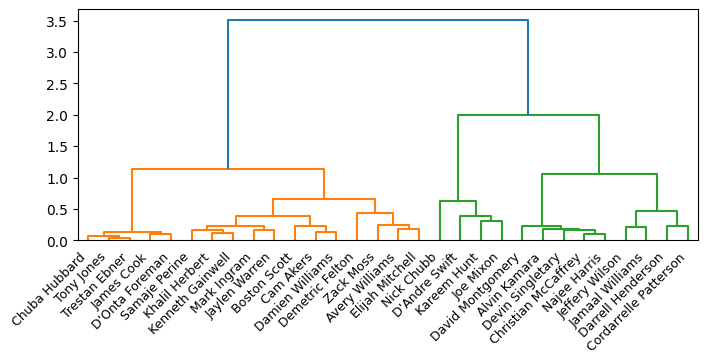

In [326]:
plot_df = player_df.drop('Football')
plot_df = plot_df.query("position == 'RB'")
plot_df = plot_df.drop(['nflId', 'position'],axis=1)

plot_df = plot_df.iloc[0:30]

plot_embed_player_df(plot_df)


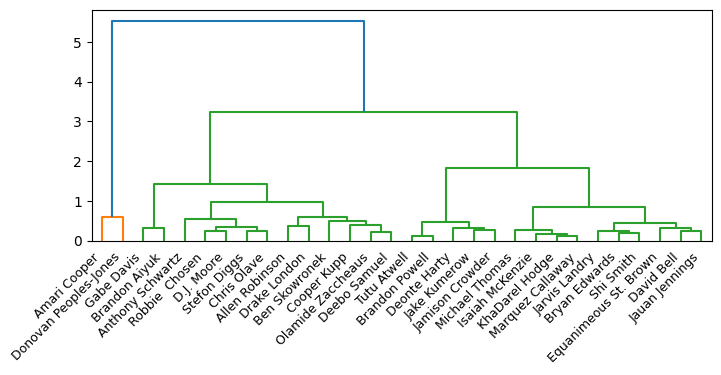

In [327]:
plot_df = player_df.drop('Football')
plot_df = plot_df.query("position == 'WR'")
plot_df = plot_df.drop(['nflId', 'position'],axis=1)

plot_df = plot_df.iloc[0:30]

plot_embed_player_df(plot_df)

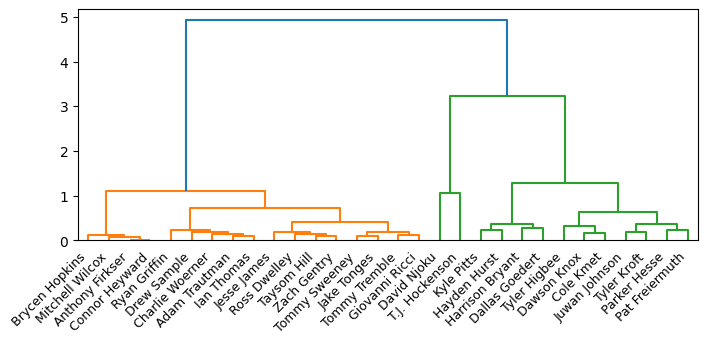

In [328]:
plot_df = player_df.drop('Football')
plot_df = plot_df.query("position == 'TE'")
plot_df = plot_df.drop(['nflId', 'position'],axis=1)

plot_df = plot_df.iloc[0:30]

plot_embed_player_df(plot_df)

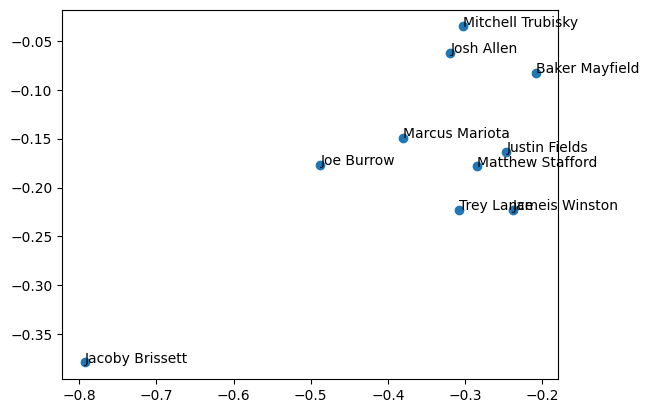

In [289]:
dim1 = 0
dim2 = 8

#fig, (ax,ax2) = plt.subplots(1, 2, figsize=(self.FIG_WIDTH, self.FIG_HEIGHT))
fig, ax = plt.subplots(1, 1)

ax.scatter(plot_df.iloc[:,dim1], plot_df.iloc[:,dim2], )

for i, txt_name in enumerate(plot_df.index[0:10]):
    ax.annotate(txt_name, (plot_df.iloc[i,dim1], plot_df.iloc[i,dim2]))



### Q3) Position Similarity

In [ ]:
''' 
given two positions, compute:
        - avg. similarity within position
        - avg. similiarity with other position

position strings need to be capitalized
player_df: df of player embeddings, with names as index, with embedding columns, nflId, and position
'''

def position_similarities(pos1:str, pos2:str, player_df:pd.DataFrame, verbose=False):
        pos1 = player_df.query('position == @pos1')
        pos2 = player_df.query('position == @pos2')
        all_players = pd.concat([pos1, pos2]).drop(['nflId', 'position'],axis=1)

        num_pos1 = len(pos1)
        num_pos2 = len(pos2)

        sim_every_player = cosine_similarity(all_players)
        sim_every_player_df = pd.DataFrame(sim_every_player)#, index=all_players.index, columns=all_players.index)

        pos1_pos1_similarity = sim_every_player_df.iloc[0:num_pos1, 0:num_pos1].mean(axis=None)   # returns scalar, average over all
        pos2_pos2_similarity = sim_every_player_df.iloc[num_pos1:, num_pos1:].mean(axis=None)   # returns scalar, average over all
        pos1_pos2_similarity = sim_every_player_df.iloc[num_pos1:, 0:num_pos1].mean(axis=None)
        pos2_pos1_similarity = sim_every_player_df.iloc[0:num_pos1, num_pos1:].mean(axis=None)

        if verbose:
                print(f"pos1_pos1_similarity = {pos1_pos1_similarity}")
                print(f"pos2_pos2_similarity = {pos2_pos2_similarity}")
                print(f"rb_wr_similarity = {pos1_pos2_similarity}")
                print(f"wr_rb_similarity = {pos2_pos1_similarity}")
        
        return [pos1_pos1_similarity, pos2_pos2_similarity, pos1_pos2_similarity, pos2_pos1_similarity]


In [232]:
player_df.position.unique()

array(['CB', 'WR', nan, 'SS', 'TE', 'FS', 'G', 'ILB', 'OLB', 'RB', 'DT',
       'T', 'C', 'NT', 'QB', 'DE', 'FB', 'MLB', 'DB'], dtype=object)

In [234]:
player_df.position.value_counts()

position
WR     156
CB     124
OLB    101
TE      96
DE      93
DT      93
T       88
RB      83
G       75
ILB     65
FS      55
SS      48
C       40
QB      39
NT      26
FB      13
MLB      6
DB       1
Name: count, dtype: int64

In [239]:
rb_wr = position_similarities('RB', 'WR', player_df)
rb_te = position_similarities('RB', 'TE', player_df)
qb_wr = position_similarities('QB', 'WR', player_df)
qb_rb = position_similarities('QB', 'RB', player_df)

c_g = position_similarities('C', 'G', player_df)
c_wr = position_similarities('C', 'WR', player_df)
de_wr = position_similarities('DE', 'WR', player_df)
de_ss = position_similarities('DE', 'SS', player_df)


In [240]:
print(f"rb_wr: {rb_wr[0]}, {rb_wr[1]}, {rb_wr[3]}")
print(f"rb_te: {rb_te[0]}, {rb_te[1]}, {rb_te[3]}")
print(f"qb_wr: {qb_wr[0]}, {qb_wr[1]}, {qb_wr[3]}")
print(f"qb_rb: {qb_rb[0]}, {qb_rb[1]}, {qb_rb[3]}")
print(f"c_g: {c_g[0]}, {c_g[1]}, {c_g[3]}")
print(f"c_wr: {c_wr[0]}, {c_wr[1]}, {c_wr[3]}")
print(f"de_wr: {de_wr[0]}, {de_wr[1]}, {de_wr[3]}")
print(f"de_ss: {de_ss[0]}, {de_ss[1]}, {de_ss[3]}")

rb_wr: 0.9280410151732115, 0.928541067278381, 0.8681564702205361
rb_te: 0.9280410151732115, 0.9358072859746378, 0.9217730418358844
qb_wr: 0.949230159278877, 0.928541067278381, 0.8918381075219807
qb_rb: 0.949230159278877, 0.9280410151732115, 0.9325190958992846
c_g: 0.9804797338095819, 0.9520175171986646, 0.9568556666332524
c_wr: 0.9804797338095819, 0.928541067278381, 0.5298870192140935
de_wr: 0.9331501235042586, 0.928541067278381, 0.6876526099747181
de_ss: 0.9331501235042586, 0.91498124646145, 0.741071499458384


In [ ]:
''' 
Embeddings by position look good! Dissimilar positions are different, similar are close
'''

In [ ]:
rbs = player_df.query('position == "RB"').iloc[14:,]    # do to put CMC first
wrs = player_df.query('position == "WR"')
all_players = pd.concat([rbs, wrs]).drop(['nflId', 'position'],axis=1)

num_rbs = len(rbs)
num_wrs = len(wrs)

In [221]:
sim_every_player = cosine_similarity(all_players)
sim_every_player_df = pd.DataFrame(sim_every_player, index=all_players.index, columns=all_players.index)

In [ ]:
# to calculate RB->RB similarity, take RB columns and RB rows
# to calculate WR->RB similarity, take WR columns and WR rows; how similar is the average WR to every RB

# get similarity average for column player, of all row players

In [227]:
rb_rb_similarity = sim_every_player_df.iloc[0:num_rbs, 0:num_rbs].mean(axis=None)   # returns scalar, average over all
wr_wr_similarity = sim_every_player_df.iloc[num_rbs:, num_rbs:].mean(axis=None)   # returns scalar, average over all

In [230]:
rb_wr_similarity = sim_every_player_df.iloc[num_rbs:, 0:num_rbs].mean(axis=None)
wr_rb_similarity = sim_every_player_df.iloc[0:num_rbs, num_rbs:].mean(axis=None)

In [231]:
print(f"rb_rb_similarity = {rb_rb_similarity}")
print(f"wr_wr_similarity = {wr_wr_similarity}")

print(f"rb_wr_similarity = {rb_wr_similarity}")
print(f"wr_rb_similarity = {wr_rb_similarity}")

rb_rb_similarity = 0.9331958696163554
wr_wr_similarity = 0.928541067278381
rb_wr_similarity = 0.866963641069601
wr_rb_similarity = 0.866963641069601


In [222]:
sim_every_player_df.head()

displayName,Christian McCaffrey,D'Onta Foreman,Chuba Hubbard,Khalil Herbert,Elijah Mitchell,Jeffery Wilson,David Montgomery,Trestan Ebner,Najee Harris,Joe Mixon,...,DK Metcalf,Tyler Lockett,Marquise Goodwin,K.J. Hamler,Courtland Sutton,Jerry Jeudy,Tyrie Cleveland,Dareke Young,D'Wayne Eskridge,Dezmon Patmon
displayName,,,,,,,,,,,,,,,,,,,,,
Christian McCaffrey,1.000000,0.953100,0.899227,0.974312,0.836622,0.920576,0.974542,0.775079,0.994312,0.966937,...,0.822344,0.856679,0.825275,0.825078,0.839333,0.827916,0.761256,0.744091,0.767847,0.799078
D'Onta Foreman,0.953100,1.000000,0.888258,0.927588,0.740901,0.851959,0.927335,0.687249,0.954643,0.897843,...,0.681800,0.756921,0.708840,0.686443,0.730180,0.722142,0.591305,0.664858,0.692848,0.704724
Chuba Hubbard,0.899227,0.888258,1.000000,0.824960,0.580351,0.735934,0.891795,0.510624,0.896183,0.793880,...,0.580459,0.593814,0.574492,0.556488,0.589967,0.574929,0.525632,0.494581,0.494691,0.548380
Khalil Herbert,0.974312,0.927588,0.824960,1.000000,0.877584,0.916634,0.970748,0.820124,0.974988,0.975202,...,0.827727,0.879980,0.848760,0.847035,0.855574,0.854019,0.758609,0.768314,0.821235,0.811819
Elijah Mitchell,0.836622,0.740901,0.580351,0.877584,1.000000,0.929090,0.801827,0.972486,0.844182,0.936892,...,0.941946,0.986986,0.985572,0.937642,0.979121,0.991383,0.842845,0.934609,0.965002,0.941189


In [76]:
player_embed_df = pd.DataFrame.from_dict(id_to_arr_dict,orient = 'index')
player_embed_df.index = player_embed_df.index.astype('float64')

In [102]:
mer = pd.merge(player_embed_df, players.loc[:,['nflId','position', 'displayName']], how='left', left_index=True, right_on='nflId').reset_index(drop=True)

In [103]:
mer.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,nflId,position,displayName
0,-0.062872,-0.405226,0.273107,0.311172,-0.104066,-0.297701,0.485456,0.228561,-0.199228,-0.055971,...,-0.106570,-0.138915,0.229759,-0.029538,-0.242523,-0.321122,-0.144659,47862.0,CB,David Long
1,-0.165383,-0.552650,0.432772,0.431883,-0.152113,-0.445856,0.738256,0.317539,-0.243720,0.012603,...,-0.079913,-0.278929,0.304479,-0.128538,-0.431377,-0.519328,-0.246035,52536.0,WR,Gabe Davis
2,-0.203914,-0.503154,0.485123,0.405431,-0.226808,-0.393721,0.740581,0.296420,-0.178967,-0.096370,...,-0.131274,-0.142387,0.312791,0.012729,-0.346933,-0.436620,-0.101270,42816.0,CB,Troy Hill
3,-1.395012,-3.590700,2.347522,1.825898,-0.024598,-1.854581,4.041639,0.391477,-0.949071,0.406346,...,0.041320,-1.431545,0.978872,-0.193240,-2.650906,-2.118295,-1.186352,NaN,NaN,NaN
4,-0.288867,-0.470623,0.428728,0.312934,-0.134726,-0.223905,0.702216,0.211098,-0.043509,-0.083744,...,0.037600,-0.128689,0.135237,0.125116,-0.323188,-0.259988,-0.023304,48026.0,SS,Nick Scott


In [111]:
rbs = mer.query('position == "RB"').iloc[-5:,]

In [112]:
wrs = mer.query('position == "WR"').iloc[0:5,:]

In [125]:
names = rbs.displayName.to_list() + wrs.displayName.to_list()

In [114]:
together = pd.concat([rbs.loc[:,0:31], wrs.loc[:,0:31]])

In [116]:
sim = cosine_similarity(together)

In [126]:
pd.DataFrame(sim, index=names, columns=names)

,Nick Chubb,Kareem Hunt,Christian McCaffrey,D'Onta Foreman,Chuba Hubbard,Gabe Davis,Isaiah McKenzie,Stefon Diggs,Ben Skowronek,Cooper Kupp
Nick Chubb,1.000000,0.979055,0.955789,0.866123,0.704760,0.897153,0.944228,0.908273,0.932830,0.990045
Kareem Hunt,0.979055,1.000000,0.977363,0.890675,0.792490,0.844882,0.908033,0.879513,0.871745,0.956089
Christian McCaffrey,0.955789,0.977363,1.000000,0.929225,0.855244,0.797923,0.849929,0.840981,0.844797,0.932791
D'Onta Foreman,0.866123,0.890675,0.929225,1.000000,0.887047,0.669753,0.709678,0.703618,0.712645,0.816593
Chuba Hubbard,0.704760,0.792490,0.855244,0.887047,1.000000,0.456539,0.515040,0.512661,0.512802,0.641296
Gabe Davis,0.897153,0.844882,0.797923,0.669753,0.456539,1.000000,0.948503,0.950285,0.978792,0.929771
Isaiah McKenzie,0.944228,0.908033,0.849929,0.709678,0.515040,0.948503,1.000000,0.965176,0.953717,0.964770
Stefon Diggs,0.908273,0.879513,0.840981,0.703618,0.512661,0.950285,0.965176,1.000000,0.931794,0.941371
Ben Skowronek,0.932830,0.871745,0.844797,0.712645,0.512802,0.978792,0.953717,0.931794,1.000000,0.960746
Cooper Kupp,0.990045,0.956089,0.932791,0.816593,0.641296,0.929771,0.964770,0.941371,0.960746,1.000000


In [150]:
''' start with one frame example '''
game_ex = all_games[0]
play_ex = 56
ngs_full_play = ngs_df.loc[(ngs_df.gameId == game_ex) & (ngs_df.playId == play_ex)].copy()
one_frame = ngs_full_play.loc[ngs_full_play.frameId == 4].copy()

In [ ]:
''' 
Need to create an edgelist where, for each player:
    - not connected if on different team
    - get distance between each teammate
'''

In [162]:
for key,index in model.wv.key_to_index.items():
    id_to_arr_dict[str(key)] = model.wv[str(key)]

In [163]:
id_to_arr_dict

{'42816.0': array([-0.00432306, -0.00356145,  0.0188583 ,  0.02890683, -0.02892803,
        -0.02547305,  0.02504901,  0.02962369, -0.01748986, -0.01319132,
         0.02504502, -0.00620271, -0.01400348,  0.0206794 , -0.0150445 ,
        -0.00895546,  0.00839886,  0.00483643, -0.02456435, -0.02881522,
         0.02200044,  0.01952611,  0.02519961,  0.00103268,  0.02038438,
        -0.01065706, -0.00506997,  0.02009873, -0.02382921, -0.01723095,
        -0.0256714 , -0.00451483], dtype=float32),
 '52536.0': array([ 0.02560884, -0.03128445, -0.00198169, -0.00442433,  0.02508119,
        -0.02393123,  0.00742388, -0.01305808, -0.03263943,  0.01419365,
        -0.02477444, -0.01580718, -0.00019124, -0.00122043, -0.02373922,
         0.02491481,  0.01493237,  0.03232132, -0.02427554,  0.015013  ,
        -0.0132715 ,  0.00868412,  0.03358924, -0.01552043,  0.01539974,
        -0.0213783 , -0.01490757,  0.03266846, -0.00565001, -0.00757905,
        -0.01782788, -0.02717827], dtype=float32),


In [78]:
model.wv.key_to_index

{'52536.0': 0,
 '42816.0': 1,
 '52607.0': 2,
 '48026.0': 3,
 '43294.0': 4,
 '44985.0': 5,
 '53532.0': 6,
 '42489.0': 7,
 '47917.0': 8,
 '47844.0': 9,
 '47879.0': 10,
 '41239.0': 11,
 '43298.0': 12,
 'nan': 13,
 '53522.0': 14,
 '44875.0': 15,
 '47857.0': 16,
 '48512.0': 17,
 '38577.0': 18,
 '43335.0': 19,
 '46076.0': 20,
 '42392.0': 21,
 '35472.0': 22}